In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from scipy.misc import imresize

%matplotlib inline
import pylab as pl
from IPython import display
import time

torch.cuda.set_device(3)

In [2]:
criterion = nn.MSELoss()
targ = Variable(torch.zeros(4))
engine = nn.Linear(8,4)
engine.weight.data.fill_(1)
engine.bias.data.fill_(1)
test = Variable(torch.ones(8))
test[4:] = 0
out = engine(test)
loss1 = criterion(out,targ)
loss1.backward(retain_graph=True)
print(engine.weight.grad)

Variable containing:
 2.5000  2.5000  2.5000  2.5000  0.0000  0.0000  0.0000  0.0000
 2.5000  2.5000  2.5000  2.5000  0.0000  0.0000  0.0000  0.0000
 2.5000  2.5000  2.5000  2.5000  0.0000  0.0000  0.0000  0.0000
 2.5000  2.5000  2.5000  2.5000  0.0000  0.0000  0.0000  0.0000
[torch.FloatTensor of size (4,8)]



In [3]:
# engine.zero_grad()
test2 = torch.cat([test[:4],out],dim=0)
out2 = engine(test2)
loss2 = criterion(out2,targ)
loss2.backward()
print(engine.weight.grad)

Variable containing:
 65.0000  65.0000  65.0000  65.0000  62.5000  62.5000  62.5000  62.5000
 65.0000  65.0000  65.0000  65.0000  62.5000  62.5000  62.5000  62.5000
 65.0000  65.0000  65.0000  65.0000  62.5000  62.5000  62.5000  62.5000
 65.0000  65.0000  65.0000  65.0000  62.5000  62.5000  62.5000  62.5000
[torch.FloatTensor of size (4,8)]



In [4]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU()
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.process = nn.Sequential(
            Block(4,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.MaxPool2d(2),
            Block(64,64)
        )
        self.rechannel = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
#             nn.Sigmoid()
        )
        self.pool = nn.AvgPool2d(10)
        
    def forward(self, inp):
        out = self.process(inp)
#         outmask = self.LSM(self.rechannel(out).view(out.size(0),-1)).view(out.size(0),1,
#                                                                           out.size(2),out.size(2))
        return self.pool(out).squeeze(),self.rechannel(out)
    
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         temp1 = torch.stack([centroids]*inp.size(0))
#         temp2 = torch.stack([inp]*centroids.size(0)).transpose(0,1)
#         print(temp1.size(),temp2.size())
        distmat = torch.sum((centroids.unsqueeze(0)-inp.unsqueeze(1))**2,2).squeeze().neg_()
        probs = self.sm(distmat)
        return probs

In [5]:
def addMask(inp):
    return torch.cat([inp,torch.zeros(1,84,84)],dim=0)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225]),
    transforms.Lambda(addMask)])
raw = torch.load('/data/imagenet/photos-annotated-0-augmented.pth')
trainset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
raw = torch.load('/data/imagenet/photos-annotated-0-test.pth')
testset = [[[preprocess(r[1]),torch.Tensor(imresize(r[2],(10,10))).unsqueeze(0)/255] 
            for r in cat] for cat in raw]
del raw

In [6]:
def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way,replace=False)
    li = [[[theset[cl][i][0].view(1,4,84,84),theset[cl][i][1].view(1,10,10)] for i in 
           np.random.choice(len(theset[cl]),trainshot+testshot,replace=False)]
          for cl in classes]
    support = torch.cat([torch.cat([p[0] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    smask = torch.cat([torch.cat([p[1] for p in t[:trainshot]],dim=0) for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([torch.cat([p[0] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qmask = torch.cat([torch.cat([p[1] for p in t[trainshot:]],dim=0) for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support).cuda(),
           Variable(smask, requires_grad=False).cuda(),
           Variable(stargs).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qmask, requires_grad=False).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda()
          )

def evaluate(embed,model,criterion,way,trainshot,testshot,reps,theset):
    masktracker = 0
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
        s,_,_,q,qmask,qt = batchmaker(way,trainshot,testshot,theset)
        embeds,_ = embed(s)
        qembeds,mpreds = embed(q)
        preds = model(embeds,qembeds,way)
        
        # Val loss
        loss = criterion(preds,qt)
        losstracker += loss.data[0]
        maskloss = mcriterion(mpreds,qmask.unsqueeze(1))
        masktracker += maskloss.data[0]*10
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qt)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
    return losstracker/reps,acctracker/reps,masktracker/reps

way = 20
evalway = 5
trainshot = 5
testshot = 15
reps = 100

In [7]:
embed = ENCODER().cuda()
model = PREDICTOR().cuda()
losstracker,mlosstracker,evallosstracker,evalmlosstracker,evalacctracker = [],[],[],[],[]
optimizer = None
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

114241  parameters in neural net.


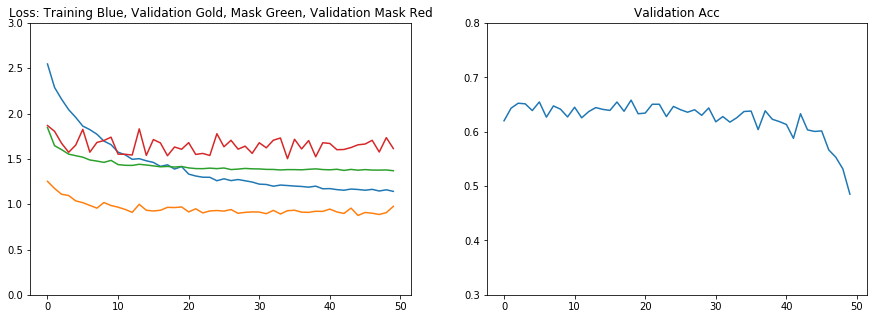

Train loss is: 1.1416207093000412
Mask MSE loss is: 1.3695384764671326

Validation accuracy is: 0.6201333333333333
Validation loss is: 0.9763348931074143
Validation mask loss is: 1.6142841160297394

2668.335291147232


In [8]:
# TRAIN!
criterion = nn.NLLLoss()
mcriterion = nn.MSELoss() #nn.BCEWithLogitsLoss()
vbity = 200
epoch = 2000
start = time.time()
factor = 10

runningloss = 0
runningmloss = 0
for it in range(5*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support, _, _, query, qmask, targs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds,_ = embed(support)
    _,mpreds = embed(query)
    newquery = torch.cat([query[:,:3,:,:],F.upsample(mpreds,size=84,mode='bilinear').detach()],dim=1)
    qembeds,_ = embed(newquery)
    preds = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    mloss = mcriterion(mpreds, qmask)*factor
    runningmloss += mloss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    totalloss = (15*loss+mloss)/16
    totalloss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        mlosstracker.append(runningmloss/vbity)
        embed = embed.eval()
        evalloss, evalacc, evalmloss = evaluate(embed,model,criterion,evalway,trainshot,testshot,
                                                reps,testset)
        embed = embed.train()
        evallosstracker.append(evalloss)
        evalmlosstracker.append(evalmloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.plot(mlosstracker)
        pl.plot(evalmlosstracker)
        pl.ylim((0,3))
        pl.title("Loss: Training Blue, Validation Gold, Mask Green, Validation Mask Red")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nMask MSE loss is: "+str(runningmloss/vbity)+
              "\n\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+
              "\nValidation mask loss is: "+str(evalmloss)+"\n")
        runningloss = 0
        runningmloss = 0
        print(time.time()-start)

# MORE RECENT TEST
        

In [ ]:
First test: no detachment, 1/2 loss ratio. 
    (0.9230986696600914, 0.637064000000071, 1.5747076343894004)
With detachment, 1/2 loss ratio.
    (0.8651500172197819, 0.6575506666667453, 1.5744320280477404)
With detachment, 15/16 loss ratio
    (0.9195982311725617, 0.6409893333334088, 1.633154151432216)      But I suspect this is an outlier

In [ ]:
#15/16: (0.8323499808594584, 0.6798600000000852, 1.4651121062263845)
#9/10: (0.8486564774314562, 0.6798888888888894, 1.4463223567853372)
#7/8: (0.8484100696980953, 0.6729893333334191, 1.4426418270468713)
#3/4: (0.8484100696980953, 0.6729893333334191, 1.4426418270468713)
#1/2: (0.8267666073277593, 0.6776586666667532, 1.3924485085904599)

In [9]:
criterion = nn.NLLLoss().cuda()
embed = embed.eval()
print(evaluate(embed,model,criterion,evalway,trainshot,testshot,10000,testset))
embed = embed.train()

/home/dww78/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()
/home/dww78/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(0.9195982311725617, 0.6409893333334088, 1.633154151432216)


In [20]:
name = 'maskpredict_mse'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker,mlosstracker,evalmlosstracker),
           '../saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'../saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
newtrainset = []
for cat in trainset:
    batch = Variable(torch.cat([i[0].view(1,3,84,84) for i in cat]), volatile=True).cuda()
    _,preds = embed(batch)
    preds = preds.data.cpu()
    print(preds.size())
    batch = batch.data.cpu()
    newcat = [torch.cat([batch[i],torch.Tensor(imresize(preds[i][0].numpy(),(84,84))).view(1,84,84)],dim=0)
              for i in range(len(cat))]
    newtrainset.append(newcat)
torch.save(newtrainset,"/data/imagenet/photos-0-maskadded-train.pth")

In [13]:
newtestset = []
for cat in testset:
    batch = Variable(torch.cat([i[0].view(1,3,84,84) for i in cat]), volatile=True).cuda()
    _,preds = embed(batch)
    preds = preds.data.cpu()
    batch = batch.data.cpu()
    newcat = [torch.cat([batch[i],torch.Tensor(imresize(preds[i][0].numpy(),(84,84))).view(1,84,84)],dim=0)
              for i in range(len(cat))]
    newtestset.append(newcat)
torch.save(newtestset,"/data/imagenet/photos-0-maskadded-test.pth")

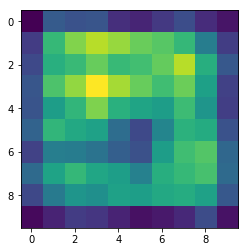

In [13]:
from matplotlib.pyplot import imshow
x = 100
imshow(mpreds[x][0].data.cpu().numpy())

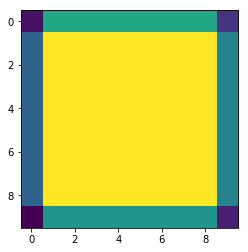

In [14]:
imshow(qmask[x].data.cpu().numpy())

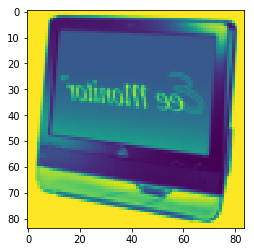

In [15]:
imshow(torch.sum(query[x],dim=0).data.cpu().numpy())


In [10]:
1.96*np.sqrt(.0090525/200)

0.01318637251104336

In [41]:
np.mean(evalacctracker[-50:])

0.5500666666666667

In [19]:
name = 'naive_full'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type PREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
embed,model,losstracker,evallosstracker,evalacctracker = torch.load('saved_models/naive_4.pth')

In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]